In [1]:
# Install Dependencies
!pip install -q timm opencv-python scikit-image albumentations

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import albumentations as A
from albumentations.pytorch import ToTensorV2

from timm import create_model

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# Dataset Constants
CLASSES = [
    'im_Dyskeratotic',
    'im_Koilocytotic',
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial_Intermediate'
]

NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms = A.Compose([
    A.Resize(224, 224),

    # Geometry (important for morphology)
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),

    # Cytology-safe color robustness
    A.RandomBrightnessContrast(
        brightness_limit=0.15,
        contrast_limit=0.15,
        p=0.7
    ),
    A.HueSaturationValue(
        hue_shift_limit=5,
        sat_shift_limit=10,
        val_shift_limit=5,
        p=0.5
    ),

    # Prevent over-sharpening
    A.GaussianBlur(blur_limit=3, p=0.15),

    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])


In [ ]:
# Custom SIPaKMeD Dataset
class SIPaKMeDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for idx, cls in enumerate(CLASSES):
            cls_path = os.path.join(root_dir, cls)
            for file in os.listdir(cls_path):
                if file.lower().endswith(".bmp"):
                    self.samples.append((os.path.join(cls_path, file), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Stain normalization
        # img = reinhard_normalization(img, TARGET_MEANS, TARGET_STDS)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, label

In [8]:
# load Dataset
train_dataset = SIPaKMeDDataset("/content/drive/MyDrive/wiseyak/cervical_cancer/SIPAKMED/Training", train_tfms)
val_dataset   = SIPaKMeDDataset("/content/drive/MyDrive/wiseyak/cervical_cancer/SIPAKMED/Test", val_tfms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Train samples: 3564
Val samples: 500


In [9]:
# Class-Weighted Loss
labels = [label for _, label in train_dataset.samples]

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

In [ ]:
# Load MobileViT-S
model = create_model(
    "mobilevit_s",
    pretrained=True,
    num_classes=NUM_CLASSES
).to(device)

print(model)

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

In [11]:
for name, param in model.named_parameters():
    print(name)


stem.conv.weight
stem.bn.weight
stem.bn.bias
stages.0.0.conv1_1x1.conv.weight
stages.0.0.conv1_1x1.bn.weight
stages.0.0.conv1_1x1.bn.bias
stages.0.0.conv2_kxk.conv.weight
stages.0.0.conv2_kxk.bn.weight
stages.0.0.conv2_kxk.bn.bias
stages.0.0.conv3_1x1.conv.weight
stages.0.0.conv3_1x1.bn.weight
stages.0.0.conv3_1x1.bn.bias
stages.1.0.conv1_1x1.conv.weight
stages.1.0.conv1_1x1.bn.weight
stages.1.0.conv1_1x1.bn.bias
stages.1.0.conv2_kxk.conv.weight
stages.1.0.conv2_kxk.bn.weight
stages.1.0.conv2_kxk.bn.bias
stages.1.0.conv3_1x1.conv.weight
stages.1.0.conv3_1x1.bn.weight
stages.1.0.conv3_1x1.bn.bias
stages.1.1.conv1_1x1.conv.weight
stages.1.1.conv1_1x1.bn.weight
stages.1.1.conv1_1x1.bn.bias
stages.1.1.conv2_kxk.conv.weight
stages.1.1.conv2_kxk.bn.weight
stages.1.1.conv2_kxk.bn.bias
stages.1.1.conv3_1x1.conv.weight
stages.1.1.conv3_1x1.bn.weight
stages.1.1.conv3_1x1.bn.bias
stages.1.2.conv1_1x1.conv.weight
stages.1.2.conv1_1x1.bn.weight
stages.1.2.conv1_1x1.bn.bias
stages.1.2.conv2_kxk.conv

In [ ]:
# Freeze entire model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classification head (timm-safe)
if hasattr(model, "head"):
    for param in model.head.parameters():
        param.requires_grad = True
else:
    raise RuntimeError("Model head not found - check timm version")


In [13]:
# Optimizer (Warm-Up Phase)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

In [14]:
# Training & Validation Functions
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader):
    model.eval()
    correct, total = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return correct / total

In [15]:
# Phase 1: Classifier Warm-Up
for epoch in range(5):
    loss = train_epoch(model, train_loader)
    acc = validate(model, val_loader)
    print(f"[Warm-Up] Epoch {epoch+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

[Warm-Up] Epoch 1 | Loss: 1.3823 | Acc: 0.7800
[Warm-Up] Epoch 2 | Loss: 1.0819 | Acc: 0.7820
[Warm-Up] Epoch 3 | Loss: 0.9209 | Acc: 0.7740
[Warm-Up] Epoch 4 | Loss: 0.8247 | Acc: 0.7780
[Warm-Up] Epoch 5 | Loss: 0.7568 | Acc: 0.8080


In [16]:
# Unfreeze Entire Model
for param in model.parameters():
    param.requires_grad = True

In [17]:
# Optimizer + Scheduler (Fine-Tuning)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [18]:
# Phase 2: Full Fine-Tuning
for epoch in range(20):
    loss = train_epoch(model, train_loader)
    acc = validate(model, val_loader)
    scheduler.step()

    print(f"[Fine-Tune] Epoch {epoch+1} | Loss: {loss:.4f} | Acc: {acc:.4f}")

[Fine-Tune] Epoch 1 | Loss: 0.4757 | Acc: 0.9040
[Fine-Tune] Epoch 2 | Loss: 0.3806 | Acc: 0.9160
[Fine-Tune] Epoch 3 | Loss: 0.3395 | Acc: 0.8980
[Fine-Tune] Epoch 4 | Loss: 0.3223 | Acc: 0.9300
[Fine-Tune] Epoch 5 | Loss: 0.3117 | Acc: 0.9460
[Fine-Tune] Epoch 6 | Loss: 0.2979 | Acc: 0.9360
[Fine-Tune] Epoch 7 | Loss: 0.2948 | Acc: 0.9500
[Fine-Tune] Epoch 8 | Loss: 0.2782 | Acc: 0.9320
[Fine-Tune] Epoch 9 | Loss: 0.2768 | Acc: 0.9400
[Fine-Tune] Epoch 10 | Loss: 0.2729 | Acc: 0.9540
[Fine-Tune] Epoch 11 | Loss: 0.2655 | Acc: 0.9500
[Fine-Tune] Epoch 12 | Loss: 0.2649 | Acc: 0.9320
[Fine-Tune] Epoch 13 | Loss: 0.2578 | Acc: 0.9460
[Fine-Tune] Epoch 14 | Loss: 0.2639 | Acc: 0.9520
[Fine-Tune] Epoch 15 | Loss: 0.2538 | Acc: 0.9480
[Fine-Tune] Epoch 16 | Loss: 0.2612 | Acc: 0.9460
[Fine-Tune] Epoch 17 | Loss: 0.2552 | Acc: 0.9380
[Fine-Tune] Epoch 18 | Loss: 0.2543 | Acc: 0.9340
[Fine-Tune] Epoch 19 | Loss: 0.2498 | Acc: 0.9360
[Fine-Tune] Epoch 20 | Loss: 0.2564 | Acc: 0.9520


In [19]:
# Save Model (Inference-Safe)
torch.save({
    "model_state": model.state_dict(),
    "classes": CLASSES
}, "mobilevit_s_sipakmed_stain_normalized.pth")

Device: cuda
Test samples: 500
Loading checkpoint...
Loaded model_state from checkpoint
Model loaded successfully!

RESULTS
---------------------------------
Total Images : 500
Correct      : 463
Wrong        : 37
Accuracy     : 92.60%

Classification Report
---------------------------------
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.96      1.00      0.98       100
            im_Koilocytotic       0.80      0.93      0.86       100
             im_Metaplastic       0.93      0.87      0.90       100
               im_Parabasal       0.97      0.98      0.98       100
im_Superficial_Intermediate       1.00      0.85      0.92       100

                   accuracy                           0.93       500
                  macro avg       0.93      0.93      0.93       500
               weighted avg       0.93      0.93      0.93       500

Confusion Matrix
---------------------------------
[[100   0   0   0   0]
 [  3  93

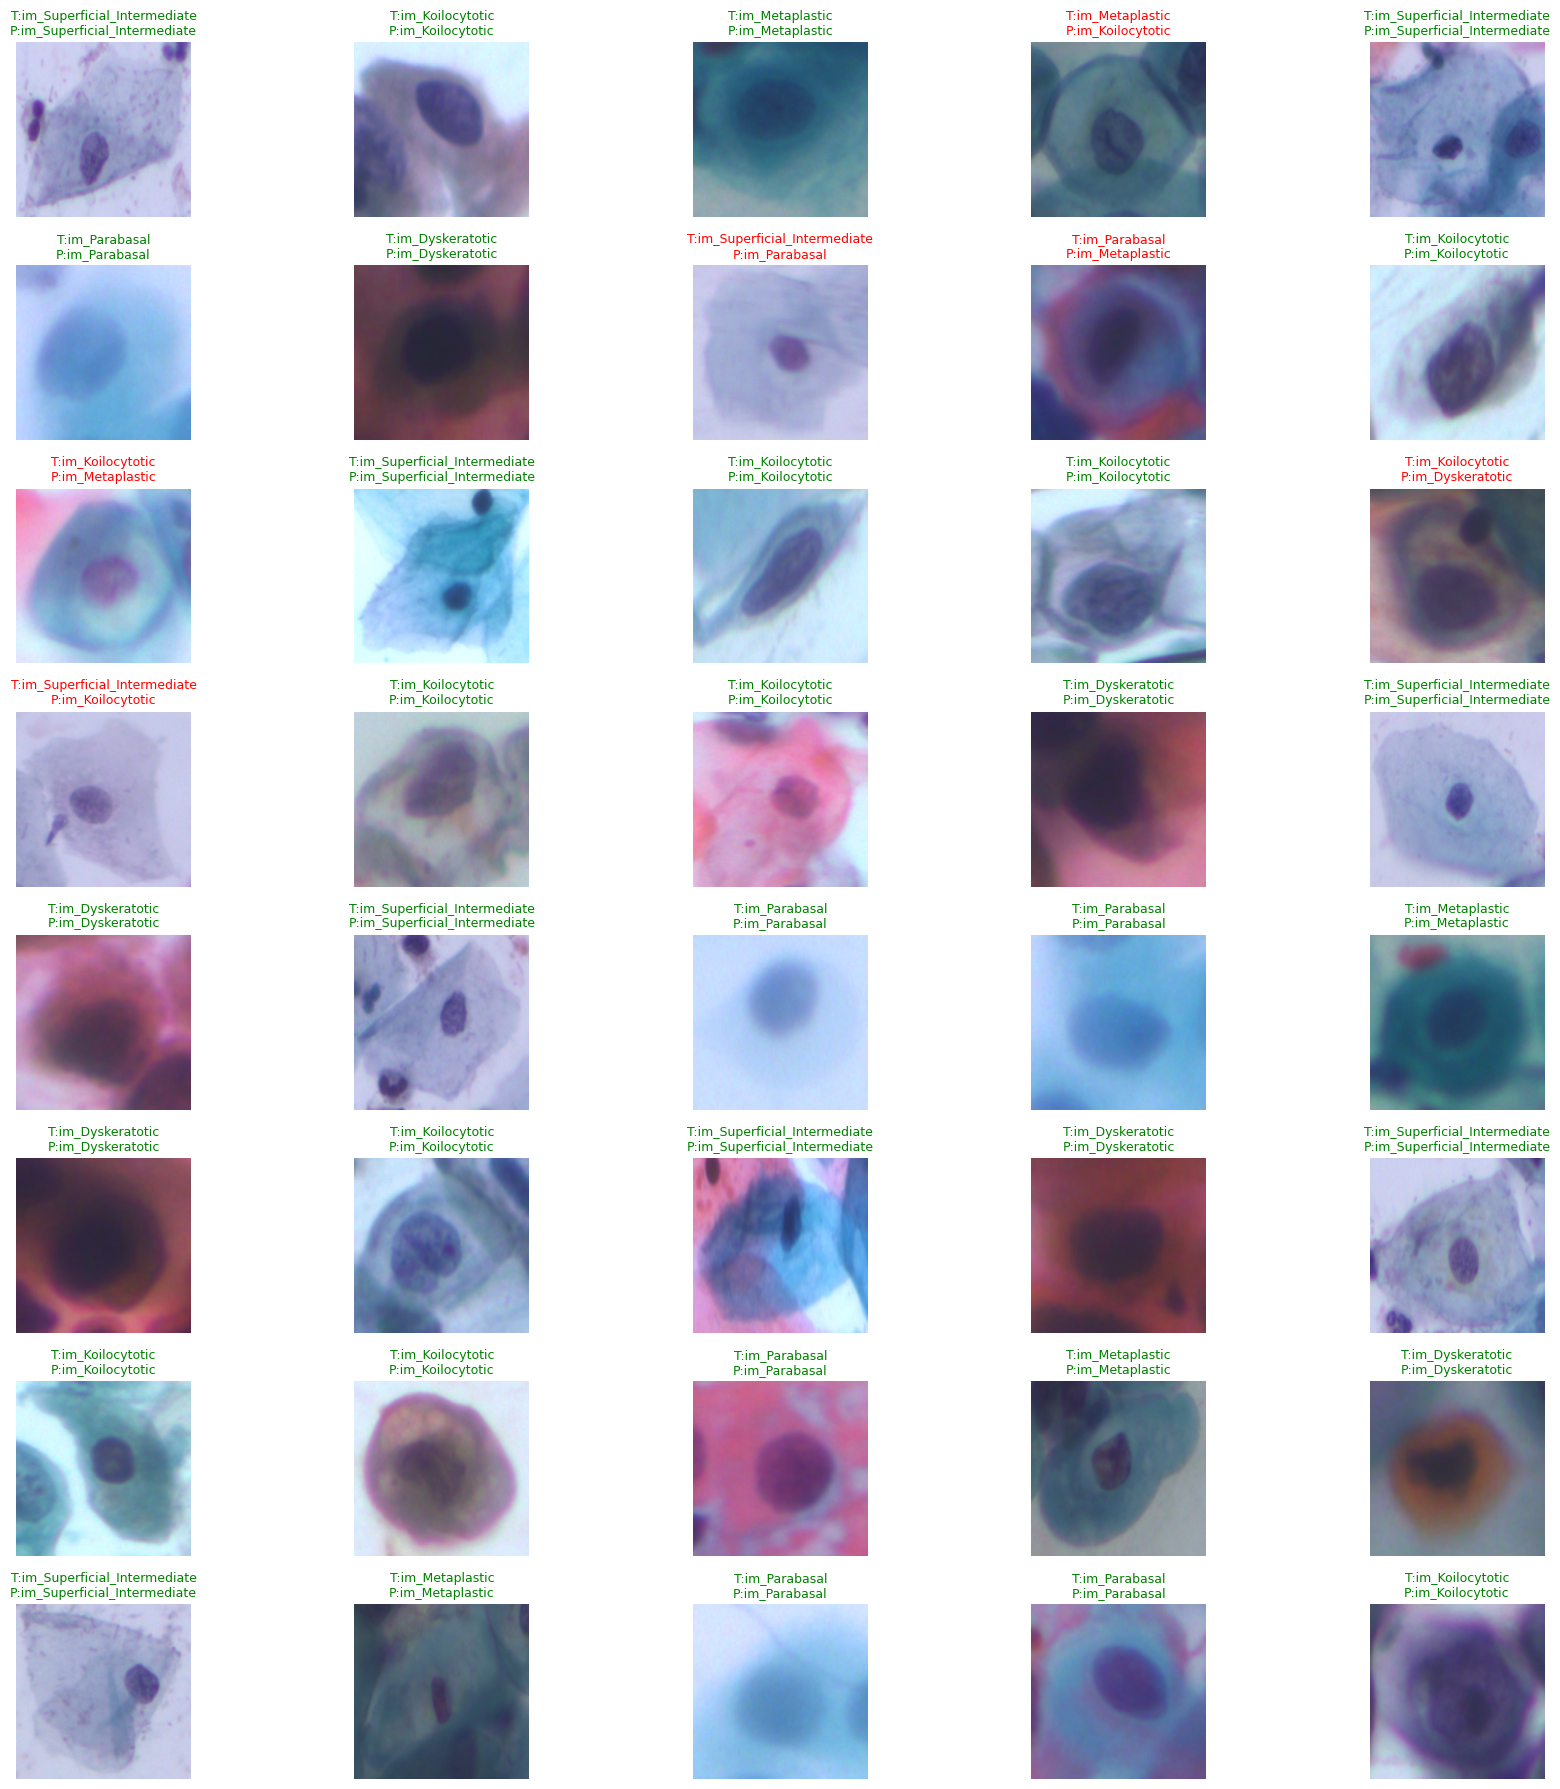


Saved annotated grid as sipakmed_test_predictions_grid.png


In [ ]:
# Infer
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import timm

# ----------------------------
# CONFIG
# ----------------------------
TEST_DIR = "/content/drive/MyDrive/wiseyak/cervical_cancer/SIPAKMED/Test"
MODEL_PATH = "/content/mobilevit_s_sipakmed_stain_normalized.pth"
BATCH_SIZE = 32
NUM_WORKERS = 2

CLASSES = [
    'im_Dyskeratotic',
    'im_Koilocytotic',
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial_Intermediate'
]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ----------------------------
# TRANSFORMS (match your val_tfms)
# ----------------------------
val_tfms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ----------------------------
# DATASET + DATALOADER
# ----------------------------
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_tfms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=NUM_WORKERS)

print("Test samples:", len(test_dataset))
assert test_dataset.classes == CLASSES, "Dataset class order mismatch!"

# ----------------------------
# LOAD MODEL
# ----------------------------
print("Loading checkpoint...")
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# If checkpoint wrapped
if "model_state" in checkpoint:
    state_dict = checkpoint["model_state"]
    print("Loaded model_state from checkpoint")
else:
    state_dict = checkpoint
    print("Loaded raw state_dict")

model = timm.create_model("mobilevit_s", pretrained=False, num_classes=len(CLASSES))
model.load_state_dict(state_dict, strict=False)

model = model.to(DEVICE)
model.eval()

print("Model loaded successfully!")


# ----------------------------
# INFERENCE
# ----------------------------
all_preds = []
all_labels = []
correct = 0
total = 0

annot_images = []   # store images for later visualization
annot_preds = []
annot_true = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # store sample images for annotation
        for i in range(imgs.size(0)):
            if len(annot_images) < 2000:  
                annot_images.append(imgs[i].cpu())
                annot_preds.append(preds[i].cpu().item())
                annot_true.append(labels[i].cpu().item())

# ----------------------------
# METRICS
# ----------------------------
wrong = total - correct
accuracy = 100.0 * correct / total

print("\nRESULTS")
print("---------------------------------")
print(f"Total Images : {total}")
print(f"Correct      : {correct}")
print(f"Wrong        : {wrong}")
print(f"Accuracy     : {accuracy:.2f}%\n")

print("Classification Report")
print("---------------------------------")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

print("Confusion Matrix")
print("---------------------------------")
print(confusion_matrix(all_labels, all_preds))

# ----------------------------
# SHOW 40 RANDOM ANNOTATED IMAGES
# ----------------------------
print("\nShowing 40 random annotated samples...")

indices = list(range(len(annot_images)))
random.shuffle(indices)
indices = indices[:40]

fig = plt.figure(figsize=(18, 18))

for i, idx in enumerate(indices):
    img = annot_images[idx]
    img = img.permute(1, 2, 0).numpy()
    img = np.clip((img * 0.229 + 0.485), 0, 1)  # unnormalize

    true_label = CLASSES[annot_true[idx]]
    pred_label = CLASSES[annot_preds[idx]]

    plt.subplot(8, 5, i + 1)
    plt.imshow(img)
    color = "green" if true_label == pred_label else "red"
    plt.title(f"T:{true_label}\nP:{pred_label}", color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.savefig("sipakmed_test_predictions_grid.png", dpi=300)
plt.show()

print("\nSaved annotated grid as sipakmed_test_predictions_grid.png")
